# L3: Image generation app 🎨

Load your HF API key and relevant Python libraries

In [4]:
import os
import io
import IPython.display
from PIL import Image
import base64 
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
hf_api_key = os.environ['HF_API_KEY']

In [5]:
# Helper function
import requests, json

#Text-to-image endpoint
def get_completion(inputs, parameters=None, ENDPOINT_URL=os.environ['HF_API_TTI_BASE']):
    headers = {
      "Authorization": f"Bearer {hf_api_key}",
      "Content-Type": "application/json"
    }   
    data = { "inputs": inputs }
    if parameters is not None:
        data.update({"parameters": parameters})
    response = requests.request("POST",
                                ENDPOINT_URL,
                                headers=headers,
                                data=json.dumps(data))
    return json.loads(response.content.decode("utf-8"))

## Building an image generation app 

Here we are going to run `runwayml/stable-diffusion-v1-5` using the `🧨 diffusers` library.

### How about running it locally?
The code would look very similar if you were running it locally instead of from an API.
```py
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

def get_completion(prompt):
    return pipeline(prompt).images[0]    
```


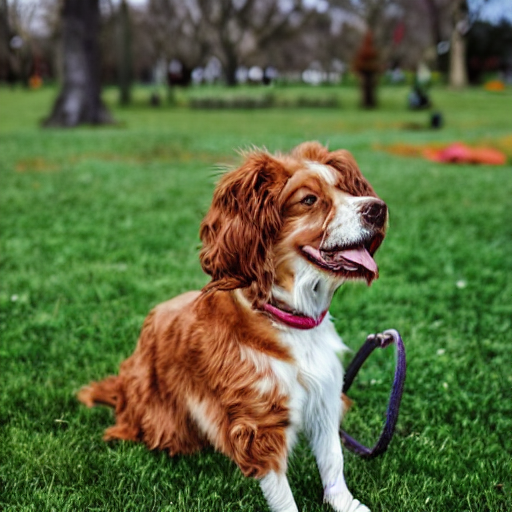

In [6]:
prompt = "a dog in a park"

result = get_completion(prompt)
IPython.display.HTML(f'<img src="data:image/png;base64,{result}" />')

## Generating with `gr.Interface()`

In [7]:
import gradio as gr 

#A helper function to convert the PIL image to base64
#so you can send it to the API
def base64_to_pil(img_base64):
    base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(base64_decoded)
    pil_image = Image.open(byte_stream)
    return pil_image

def generate(prompt):
    output = get_completion(prompt)
    result_image = base64_to_pil(output)
    return result_image

gr.close_all()
demo = gr.Interface(fn=generate,
                    inputs=[gr.Textbox(label="Your prompt")],
                    outputs=[gr.Image(label="Result")],
                    title="Image Generation with Stable Diffusion",
                    description="Generate any image with Stable Diffusion",
                    allow_flagging="never",
                    examples=["the spirit of a tamagotchi wandering in the city of Vienna","a mecha robot in a favela"])

demo.launch(share=True, server_port=int(os.environ['PORT1']))

Running on local URL:  https://0.0.0.0:52281

Could not create share link. Missing file: /usr/local/lib/python3.9/site-packages/gradio/frpc_linux_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_linux_amd64
2. Rename the downloaded file to: frpc_linux_amd64_v0.2
3. Move the file to this location: /usr/local/lib/python3.9/site-packages/gradio


In [8]:
demo.close()

Closing server running on port: 52281


## Building a more advanced interface

In [9]:
import gradio as gr 

#A helper function to convert the PIL image to base64 
# so you can send it to the API
def base64_to_pil(img_base64):
    base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(base64_decoded)
    pil_image = Image.open(byte_stream)
    return pil_image

def generate(prompt, negative_prompt, steps, guidance, width, height):
    params = {
        "negative_prompt": negative_prompt,
        "num_inference_steps": steps,
        "guidance_scale": guidance,
        "width": width,
        "height": height
    }
    
    output = get_completion(prompt, params)
    pil_image = base64_to_pil(output)
    return pil_image

gr.close_all()
demo = gr.Interface(fn=generate,
                    inputs=[
                        gr.Textbox(label="Your prompt"),
                        gr.Textbox(label="Negative prompt"),
                        gr.Slider(label="Inference Steps", minimum=1, maximum=100, value=25,
                                 info="In how many steps will the denoiser denoise the image?"),
                        gr.Slider(label="Guidance Scale", minimum=1, maximum=20, value=7, 
                                  info="Controls how much the text prompt influences the result"),
                        gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512),
                        gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512),
                    ],
                    outputs=[gr.Image(label="Result")],
                    title="Image Generation with Stable Diffusion",
                    description="Generate any image with Stable Diffusion",
                    allow_flagging="never"
                    )

demo.launch(share=True, server_port=int(os.environ['PORT2']))

Closing server running on port: 52281
Running on local URL:  https://0.0.0.0:22006

Could not create share link. Missing file: /usr/local/lib/python3.9/site-packages/gradio/frpc_linux_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_linux_amd64
2. Rename the downloaded file to: frpc_linux_amd64_v0.2
3. Move the file to this location: /usr/local/lib/python3.9/site-packages/gradio


In [10]:
demo.close()

Closing server running on port: 22006


## `gr.Blocks()` to the rescue!

In [11]:
with gr.Blocks() as demo:
    gr.Markdown("# Image Generation with Stable Diffusion")
    prompt = gr.Textbox(label="Your prompt")
    with gr.Row():
        with gr.Column():
            negative_prompt = gr.Textbox(label="Negative prompt")
            steps = gr.Slider(label="Inference Steps", minimum=1, maximum=100, value=25,
                      info="In many steps will the denoiser denoise the image?")
            guidance = gr.Slider(label="Guidance Scale", minimum=1, maximum=20, value=7,
                      info="Controls how much the text prompt influences the result")
            width = gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512)
            height = gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512)
            btn = gr.Button("Submit")
        with gr.Column():
            output = gr.Image(label="Result")

    btn.click(fn=generate, inputs=[prompt,negative_prompt,steps,guidance,width,height], outputs=[output])
gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT3']))

Closing server running on port: 52281
Closing server running on port: 22006
Running on local URL:  https://0.0.0.0:44390

Could not create share link. Missing file: /usr/local/lib/python3.9/site-packages/gradio/frpc_linux_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_linux_amd64
2. Rename the downloaded file to: frpc_linux_amd64_v0.2
3. Move the file to this location: /usr/local/lib/python3.9/site-packages/gradio


In [12]:
with gr.Blocks() as demo:
    gr.Markdown("# Image Generation with Stable Diffusion")
    with gr.Row():
        with gr.Column(scale=4):
            prompt = gr.Textbox(label="Your prompt") #Give prompt some real estate
        with gr.Column(scale=1, min_width=50):
            btn = gr.Button("Submit") #Submit button side by side!
    with gr.Accordion("Advanced options", open=False): #Let's hide the advanced options!
            negative_prompt = gr.Textbox(label="Negative prompt")
            with gr.Row():
                with gr.Column():
                    steps = gr.Slider(label="Inference Steps", minimum=1, maximum=100, value=25,
                      info="In many steps will the denoiser denoise the image?")
                    guidance = gr.Slider(label="Guidance Scale", minimum=1, maximum=20, value=7,
                      info="Controls how much the text prompt influences the result")
                with gr.Column():
                    width = gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512)
                    height = gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512)
    output = gr.Image(label="Result") #Move the output up too
            
    btn.click(fn=generate, inputs=[prompt,negative_prompt,steps,guidance,width,height], outputs=[output])

gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT4']))

Closing server running on port: 52281
Closing server running on port: 22006
Running on local URL:  https://0.0.0.0:39059

Could not create share link. Missing file: /usr/local/lib/python3.9/site-packages/gradio/frpc_linux_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_linux_amd64
2. Rename the downloaded file to: frpc_linux_amd64_v0.2
3. Move the file to this location: /usr/local/lib/python3.9/site-packages/gradio


In [14]:
gr.close_all()

Closing server running on port: 52281
Closing server running on port: 22006
